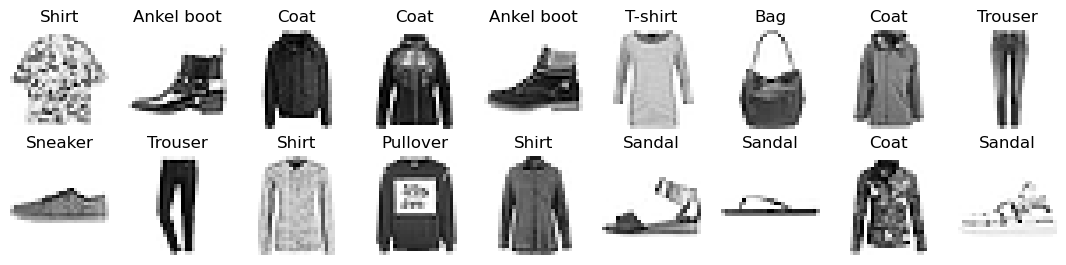

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils import data
from torchvision import transforms
from tqdm import tqdm

myseed = 1314  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

trans = transforms.ToTensor()
train_data = torchvision.datasets.FashionMNIST(
    root="./MNIST", train=True, transform=trans, download=True)
test_data  = torchvision.datasets.FashionMNIST(
    root="./MNIST", train=False, transform=trans, download=True)
device  = torch.device('cuda' if torch.cuda.is_available else 'cpu')

BATCH_SIZE = 512  

train_dataloader = data.DataLoader(dataset = train_data,batch_size = BATCH_SIZE,shuffle = True)
test_dataloader  = data.DataLoader(dataset = test_data,batch_size = 1000)

class_str = ["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankel boot"]

def get_class(indices):
    return class_str[int(indices)]

def show_img(img,label,nrow,ncol,scale=1.5):
    fig,axes = plt.subplots(nrow,ncol, figsize=(ncol*scale,nrow*scale)) 
    axes = axes.flatten()
    for i,(img,ax) in enumerate(zip(img,axes)):
        ax.imshow(img.squeeze(),cmap="Greys")
        ax.set_title(get_class(label[i]))
        ax.axis('off')
    plt.show()

x, y = next(iter(train_dataloader))
show_img(x,y,2,9)

In [2]:
class LeNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1,6,kernel_size=5,stride=1,padding=2),nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(6,16,kernel_size=5,stride=1),nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Flatten(1),
            nn.Linear(16*5*5,120),nn.ReLU(),
            nn.Linear(120,84),nn.ReLU(),
            nn.Linear(84,10),
        )

    def forward(self,x):
        x = self.layers(x)
        return x
    
x = torch.randn((2,1,28,28))
lenet = LeNet()
for layer in lenet.layers:
    x = layer(x)
    print("Name: %-10s"%(layer.__class__.__name__),'output shape: ',x.shape)

Name: Conv2d     output shape:  torch.Size([2, 6, 28, 28])
Name: ReLU       output shape:  torch.Size([2, 6, 28, 28])
Name: MaxPool2d  output shape:  torch.Size([2, 6, 14, 14])
Name: Conv2d     output shape:  torch.Size([2, 16, 10, 10])
Name: ReLU       output shape:  torch.Size([2, 16, 10, 10])
Name: MaxPool2d  output shape:  torch.Size([2, 16, 5, 5])
Name: Flatten    output shape:  torch.Size([2, 400])
Name: Linear     output shape:  torch.Size([2, 120])
Name: ReLU       output shape:  torch.Size([2, 120])
Name: Linear     output shape:  torch.Size([2, 84])
Name: ReLU       output shape:  torch.Size([2, 84])
Name: Linear     output shape:  torch.Size([2, 10])


In [3]:
def accuracy(y_pred,y):
    y_pred = y_pred.softmax(1).argmax(1)
    total = y.shape[0]
    right = (y_pred == y).sum()
    print("Acc:%d%%"%(right/total*100))
    return (right,total)


def train(train_loader,test_loader,model,n_epoch,lr,device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    model.apply(init_weights)
    model.to(device)
    optim = torch.optim.SGD(model.parameters(),lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(n_epoch):
        bar = tqdm(train_loader,total=len(train_loader),unit_scale=BATCH_SIZE)
        for x,y in bar:
            optim.zero_grad()
            x,y = x.to(device),y.to(device)
            pred = model(x)
            loss = criterion(pred,y)
            loss.backward()
            optim.step()
            bar.set_description(f'Epoch:[{epoch+1:02d}/{n_epoch}]')
            bar.set_postfix(loss=float(loss))
        with torch.no_grad():
            for x,y in test_loader:
                x,y = x.to(device),y.to(device)
                pred = model(x)
                accuracy(pred,y)
                break
            
train(train_dataloader,test_dataloader,model=lenet,n_epoch=20,lr=0.06,device=device)

Epoch:[01/20]: 100%|██████████| 60416/60416 [00:04<00:00, 13197.48it/s, loss=0.857]


Acc:62%


Epoch:[02/20]: 100%|██████████| 60416/60416 [00:02<00:00, 22823.04it/s, loss=0.513]


Acc:76%


Epoch:[03/20]: 100%|██████████| 60416/60416 [00:03<00:00, 16655.10it/s, loss=0.474]


Acc:78%


Epoch:[04/20]: 100%|██████████| 60416/60416 [00:03<00:00, 16897.45it/s, loss=0.516]


Acc:79%


Epoch:[05/20]: 100%|██████████| 60416/60416 [00:03<00:00, 16911.77it/s, loss=0.551]


Acc:78%


Epoch:[06/20]: 100%|██████████| 60416/60416 [00:03<00:00, 16756.38it/s, loss=0.494]


Acc:81%


Epoch:[07/20]: 100%|██████████| 60416/60416 [00:03<00:00, 16927.32it/s, loss=0.412]


Acc:78%


Epoch:[08/20]: 100%|██████████| 60416/60416 [00:03<00:00, 17017.31it/s, loss=0.446]


Acc:83%


Epoch:[09/20]:  92%|█████████▏| 55808/60416 [00:03<00:00, 16692.25it/s, loss=0.48] 


KeyboardInterrupt: 

In [ ]:
torch.save(lenet.state_dict(),'lenet')